In [4]:
import tensorflow as tf
import keras
from keras import layers
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import utils
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet import MobileNet

In [6]:
# Constantes
IS_TO_FIND_BEST_HYPERPARAMS = True
IS_TO_TRAIN = True
IS_TO_REPLICATE = True
BATCH_SIZE = 64
IMG_HEIGHT = 256    
IMG_WIDTH = 256

NUM_CLASSES= 1
SEED = None if IS_TO_TRAIN else 12345
MAX_EPOCHS = 50
WEIGHTS_FILENAME = "models/best_binary_model.weights.h5"
HYPERPARAMS_FILENAME = "models/best_binary_model.hyperparams.json"

In [7]:
# ficheiro onde serão guardados os pesos do "melhor modelo" - ajustar o caminho
BEST_MODEL_PATH = "tmp/best_model.weights.h5"

# callback para guardar o melhor modelo
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

In [8]:

DATASET_PATH = "./cats_and_dogs"
SEED = 7654321  # semente para o split validação/teste com melhor distribuição

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH + '/train',
    labels='inferred',
    label_mode='binary',
    seed=SEED,
    batch_size=BATCH_SIZE
)
val_ds, test_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH + '/validation',
    labels='inferred',
    label_mode='binary',
    validation_split=0.5,
    subset="both",
    seed=SEED,
    batch_size=BATCH_SIZE
)

# as labels foram inferidas a partir dos nomes dos diretórios
labels = train_ds.class_names
print("Encontradas as classes: ", labels)

# carregar os datasets em memória - uma vez carregados, a ordem dos batches já não muda
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Using 500 files for validation.
Encontradas as classes:  ['cats', 'dogs']


In [ ]:

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False


# Add your own dense layer for binary classification
catOrDog_model = keras.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Lambda(preprocess_input),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# definição do algoritmo de otimização e da função de perda (loss)
catOrDog_model.compile(optimizer='adam',
                     loss="binary_crossentropy",
                     metrics=['accuracy'])

# sumário do modelo
catOrDog_model.summary()

In [10]:
history = catOrDog_model.fit(
    train_ds,
    epochs=MAX_EPOCHS,
    validation_data=val_ds,
    callbacks=[BEST_MODEL_CHECKPOINT, EARLY_STOPPING]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.8852 - loss: 3.6852 - val_accuracy: 0.9700 - val_loss: 1.6224
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 412s 13s/step - accuracy: 0.9788 - loss: 0.8389 - val_accuracy: 0.9260 - val_loss: 4.8201
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9693 - loss: 1.6675 - val_accuracy: 0.9840 - val_loss: 0.7593
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9951 - loss: 0.1787 - val_accuracy: 0.9800 - val_loss: 0.9661
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9973 - loss: 0.0933 - val_accuracy: 0.9700 - val_loss: 1.0591
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9964 - loss: 0.1417 - val_accuracy: 0.9680 - val_loss: 1.2726
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9953 - loss: 0.1774 - val_accuracy: 0.9780 - val_loss: 0.8836
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9965 - loss: 0.1540 - val_accuracy: 0.9840 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Falhou em 8 amostras num total de 500 imagens de flores
Taxa de acertos: 98.40 %


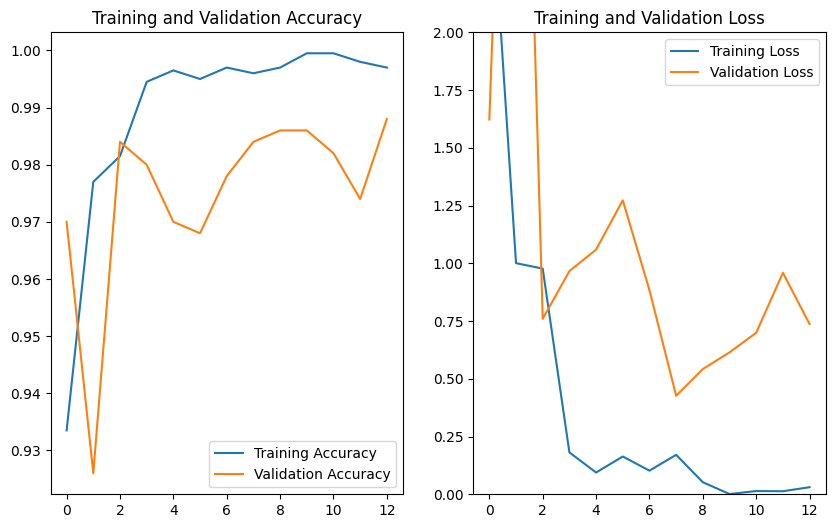

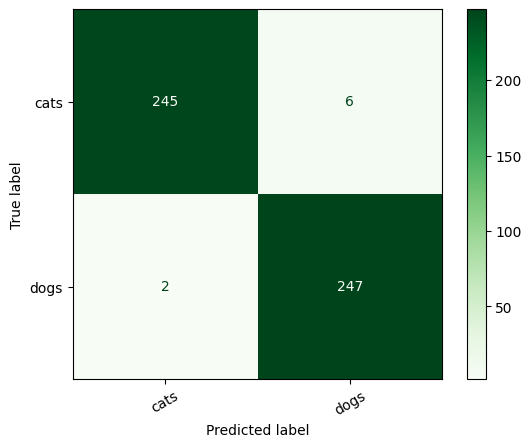

In [34]:
# carregar o melhor modelo encontrado durante o treino
catOrDog_model.load_weights(BEST_MODEL_PATH)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Make predictions
output_pred = catOrDog_model.predict(val_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

n_misses = np.count_nonzero(y_pred != y_true.flatten())
n_preds = y_pred.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print("Falhou em {:d} amostras num total de {:d} imagens de flores".format(n_misses, n_preds))
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))


# gerar gráficos e matriz de confusão
cm = confusion_matrix(y_true, y_pred)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0, 2)
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=30)
plt.show()

In [33]:

n_misses = np.count_nonzero(y_pred != y_true.flatten())
y_true_array = y_true.flatten()
print(n_misses)

8
